# Time-resolved mass spectrometry during Atomic Layer Deposition
## Motivation
Atomic Layer Deposition (or ALD) is a gas-phase technique to deposit thin films. Typically, two precursors are pulsed subsequentially, chemisorb, and react at the surface. 
Any solid reaction product remains on the surface, and ideally other reaction products leave the surface, again through the gas phase. By repeating this process multiple times, it is possible to deposit a thin film with extremely precise thickness control. 
Because of the reactivity of the precursors, this typically happens in a chemical reactor at very low pressures.

The gas-phase nature of the reaction, and makes it very interesting to probe the mixture of gases in the reactor. Typically, a quadrupole mass spectrometer is used for this task. In this device, molecules are broken up into ionized fragments, and then selected based on their mass-over-charge ratio. Using such a device, it is possible to track partial pressures of gases and their fragments extremely precisely.

However, because the chemical reactor is connected to a vacuum pump all the time, the reaction products we want to study are present in the reactor for only a short period of time. Hence, time-resolved measurements with high sensitivity are necessary. One downside of a QMS is that it can select only a single fragment (mass-to-charge) at the time. These tools have typically two modes: either one can track a single mass with good time resolution (or, a couple masses, but that comes directly comes with a trade-off in time resolution), or one can track all masses within a certain range (say, 1-200 amu), but with quite poor time resolution. If you do not know in advance which molecules are your reaction products, it becomes very easy to miss something. 

## Solution
In this work (J. Phys. Chem. C 2020, 124, 26443−26454 ([10.1021/acs.jpcc.0c07602](https://dx.doi.org/10.1021/acs.jpcc.0c07602))), we circumvented these limitations by exploiting the cyclic nature of ALD: indeed, the same reaction is repeated tens, even hundreds of times. In what is called the steady state growth mode, the reaction is the same every time. By taking slow, full range measurements during an ALD process and carefully processing them, it is possible to obtain a full, time-resolved image of what happens in the reactor during a single cycle.

In the original paper, we used this technique to study a typical ALD reaction: trimethylaluminum (TMA) and water. There are some other technical practicalities with regards to when the gas is sampled in the paper to protect the interior of the QMS to be coated. Initially, we were not taking these precautions, resulting in a coated QMS. However, the data collected is a little easier to interpret, so this notebook should serve as a tutorial on the data analysis, albeit on a more exotic process (LiHMDS and TMP, as initially developed [here](https://doi.org/10.1149/2.052203jes)). It was written quite some time after the original data was collected an the paper was published, original scripts can be found in the folder `supporting information'.

This approach has proven to be valuable to study a range of processes. For example, it was used [here](https://doi.org/10.1021/acs.jpcc.0c09284) and [here](https://doi.org/10.1021/acs.chemmater.4c03385).

It is also possible to use the reorganization approach with other 'slow' techniques. For example, we did a proof of principle with continuous spectroscopic ellipsometry to get a very good time resolution. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from SI.ms_tools import read_bar, bar_heatmap, get_singlepulse # the import of this custom function works only if you downloaded the entire repository.

# uncomment if you have ipympl installed, changing 'inline' for 'widget' this makes your graphs interactive.
# %pip install ipympl
# %matplotlib widget
%matplotlib inline

In [2]:
# load and view the data
filename = 'test_data/raw_file.csv'
p, m, t = read_bar(filename) # pressure, mass, time


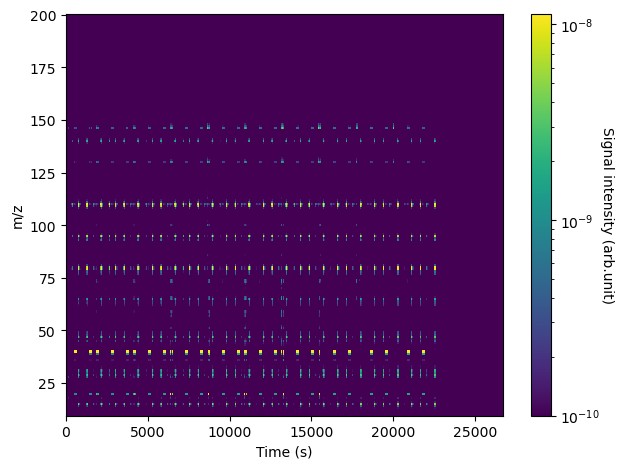

In [3]:
plt.figure()
bar_heatmap(p,m,t)

The data loaded from raw_file.csv is not ready yet: at the end, when the process finished, the QMS collected data for some longer. As we will reorganize the data, this blank end will induce unwanted artefacts. 

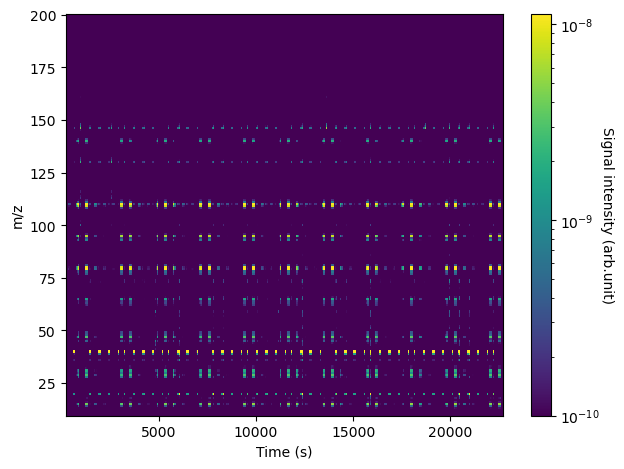

In [4]:
#  QMS cycles: start at 50, end at 950 QMS cycles before the end (the spectrometer collected a little longer after the process ended)
begin = 50 
end = -950

p = p[:,begin:end]
t = t[begin:end]

# plot cropped data
plt.figure()
bar_heatmap(p,m,t,clipmin=1e-10) # the clipmin parameter can make the visualization easier.

Now we are ready to reorganize the data. To do so effectively, we need to know the extact time each mass was collected. (the QMS gives only timestamps for an entire spectrum). Given that the QMS scans the range from low to high, we interpolate the timestamps for the spectra.

In [5]:
t = np.append(t, 2*t[-1]-t[-2]) 
t_detail = []
for i in np.arange(t.size-1):
    start = t[i]
    stop = t[i+1]
    t_detail.append(np.linspace(start, stop, m.size))
t_detail = np.array(t_detail).T

In this process, an ALD cycle took 450s (because we repeatedly pulsed precursors, in order to have an internal reference). Due to the nature of the process, the ALD cycle time is not *exactly* 450s, but we do not know how large the error is when we get the data. 

Let's first look at what happens when we reorganize the data with a cycle time of 450.

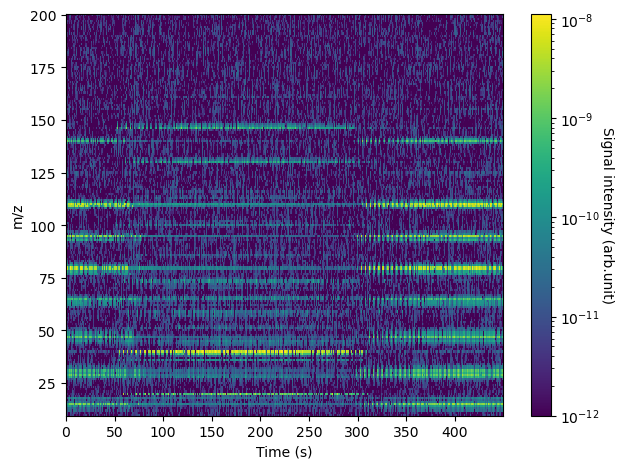

In [6]:
# ideal length of the cyle (no error) in s
cycle_length = 450
modulus = cycle_length # later, this will have the error added to this.

start_time = 10 # this is not so important, just a way to shift the begin time of the remapped spectrum

# the function get_singlepulse returns a reorganized map.
sorted_time, sorted_press, difference = get_singlepulse(start_time, modulus, t_detail, p, m, sm=True, wdw=3)

plt.figure()
bar_heatmap(sorted_press,m,sorted_time,clipmin=1e-12)

This does not look very good. Clearly some reorganization is happening, but the peaks are not nearly as defined as we would want. 
This gives us a clue as to how to find the error on the cycle time: for a very defined peak, the number of jumps (or noise) will be minimal.

We define this jumpiness as 
$$\sum_m\sum_t p_{m,t+1} - p_{m,t}$$

Actually, the function `get_singlepulse` returns the `jumpiness' of the spectrum by itself, as it is a small thing to calculate. 

To figure out the additional time one cycle took, we will scan through a range of process times, and calculate the jumpiness of each spectrum. The spectrum with minimal jumpiness will then be the one we want. This may take a while.

In [7]:
# note: running this cell may take a while (2-5 minutes seems reasonable with a resolution of 0.01, with a resolution of 0.05s this runs in 20s for me)
# it is also possible to iterate and scan a smaller space with higher resolution afterwards.
resolution = 0.05 #s

# studying a possible error on the process from -1s to +10 s (on top of the 450s originally intended)
extrashift_min = -1
extrashift_max = 10
extrashift = np.arange(extrashift_min, extrashift_max, resolution)

diff = np.zeros(extrashift.size)

for shiftindex in np.arange(extrashift.size):
    # not very important, determines where you start. The noise will remain the same.
    start_time = 0
    # extremely important
    modulus = cycle_length + extrashift[shiftindex]
    bettertime, sorted_press, d = get_singlepulse(start_time, modulus, t_detail, p, m)
    diff[shiftindex] = d

2.400000000000003


Text(0, 0.5, 'Noise')

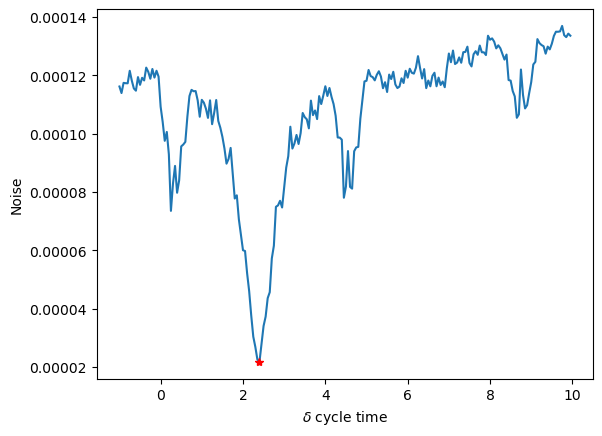

In [8]:
# Now let's plot this
opt = np.argmin(diff)
shift = extrashift[opt]
print(shift)

plt.figure()
plt.plot(extrashift, diff)
plt.plot(extrashift[opt], diff[opt], 'r*')
plt.xlabel(r'$\delta$ cycle time')
plt.ylabel('Noise')

Clearly, the minimum is on 2.35s error (+- 0.05s). That means that the *actual* process time was 450 + 2.35s.

We can also find this minimum by minimizing the noise directly (essentially, the last cell is using a very inefficient brute force approach and the optimum will depend on the chosen resolution). This was not done in the original paper, and it really is just a slightly more elegant (although still brute force) approach. 

To do so, we have to import the lmfit package.

In [9]:
from lmfit import minimize, Parameters, Parameter
# zoom in on the deepest peak
zoom_min = 2.2 #s
zoom_max = 3 # s
# note that the lm algorithm only finds local minima, so the peak has to be sufficiently constrained.

def wrap(pars):
    # first parameter is start time, which is not important.
    # the only thing that needs to be optimized is the modulus
    _, _, d = get_singlepulse(0, cycle_length + pars['shift'].value, t_detail, p, m)
    return d

params = Parameters()
params['shift'] = Parameter(name='shift', value=0, min=zoom_min, max=zoom_max)

result = minimize(wrap, params, method='lm')
# print(result.params.pretty_print())
shift = result.params['shift'].value
print(shift)

# so the actual optimal value is 2.37.

2.3826420737478853


Now, we can calculate the actual reorganized map of a time-resolved, full-range QMS spectrum during a single ALD cycle.

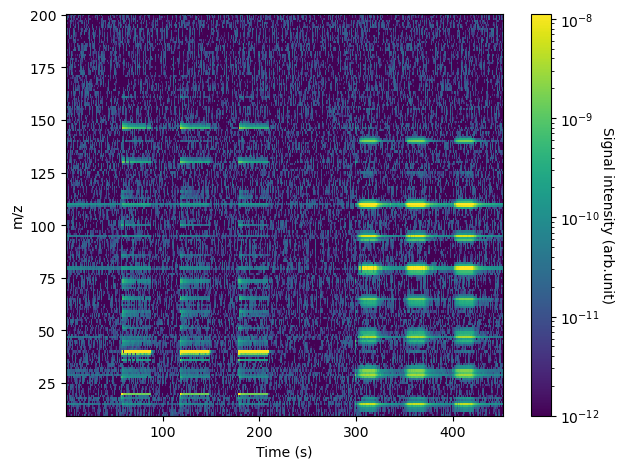

In [10]:
sorted_time, sorted_press, difference = get_singlepulse(start_time, cycle_length + shift, t_detail, p, m, sm=False)
plt.figure()
bar_heatmap(sorted_press, m, sorted_time, clipmin=1e-12)

This looks a lot better. We can clearly see the 3 LiHMDS pulses followed by 3 TMP pulses. The reaction products are present right before the TMP pulse. To make them stand out better against the background noise, we can smooth the obtained map and play with the clipmin parameter for the plot.

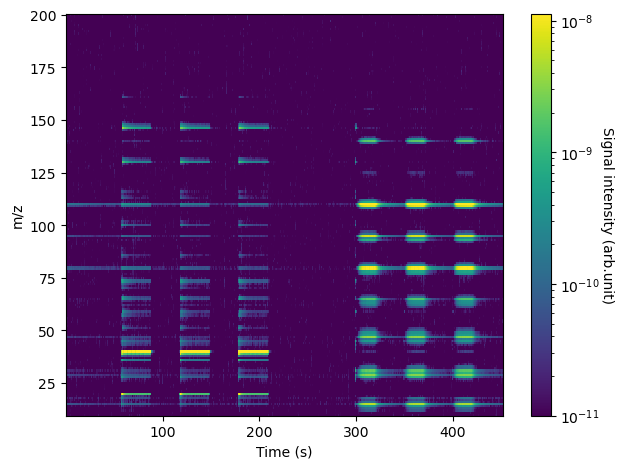

In [11]:
sorted_time, sorted_press, difference = get_singlepulse(start_time, cycle_length + shift, t_detail, p, m, sm=True, wdw=5)
plt.figure()
bar_heatmap(sorted_press, m, sorted_time, clipmin=1e-11)

To plot the reaction product mass spectrum, we can take slices of the heatmap and plot them against each other. It seems like the reaction product resembles the first precursor quite a bit. Let's compare them. 

(191,)


(1e-11, 1e-08)

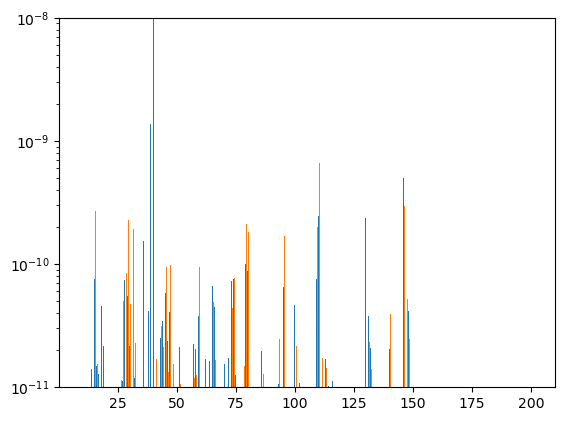

In [12]:
from SI.ms_tools import vertical_avg

# use vertical_avg function to integrate between times
_, LiHMDS_spectrum = vertical_avg(sorted_press, m, sorted_time, 75,85)
_, reaction_spectrum = vertical_avg(sorted_press, m, sorted_time, 298, 303)
print(LiHMDS_spectrum.shape)
plt.figure()
plt.bar(m, LiHMDS_spectrum, width=0.4)
plt.bar(m+0.5, reaction_spectrum, width=0.4)
plt.yscale('log')
plt.ylim([1e-11, 1e-8])

More details about this particular reaction can be found in [this paper](https://doi.org/10.1021/acs.jpcc.0c09284).